In [1]:
using LightGraphs
using MatrixNetworks
using VegaDatasets
using DataFrames
using SparseArrays
using LinearAlgebra
using Plots
using VegaLite

In [2]:
default(
    dpi=300,
    size=(800, 600),
)


In [3]:
function show_map(p, ppi=300)
    io = IOBuffer()
    Base.show(IOContext(io, :ppi => ppi), MIME"image/png"(), p)
    display("image/png", take!(io))
end

show_map (generic function with 2 methods)

In [4]:
airports = dataset("airports")
flightsairport = dataset("flights-airport")

5366x3 Vega dataset
origin │ destination │ count
───────┼─────────────┼──────
ABE    │ ATL         │ 853  
ABE    │ BHM         │ 1    
ABE    │ CLE         │ 805  
ABE    │ CLT         │ 465  
ABE    │ CVG         │ 247  
ABE    │ DTW         │ 997  
ABE    │ JFK         │ 3    
ABE    │ LGA         │ 9    
ABE    │ ORD         │ 1425 
ABE    │ PHL         │ 2    
... with 5356 more rows

In [5]:
flightsairportdf = DataFrame(flightsairport);

In [6]:
allairports = vcat(flightsairportdf[!,:origin],flightsairportdf[!,:destination])
uairports = unique(allairports);

In [7]:
# create an airports data frame that has a subset of airports that are only included in the routes dataset
airportsdf = DataFrame(airports)
subsetairports = map(i->findfirst(airportsdf[!, :iata].==uairports[i]),1:length(uairports))
airportsdf_subset = airportsdf[subsetairports,:];

In [8]:
# build the adjacency matrix
ei_ids = findfirst.(isequal.(flightsairportdf[!,:origin]), [uairports])
ej_ids = findfirst.(isequal.(flightsairportdf[!,:destination]), [uairports])
edgeweights = flightsairportdf[!,:count]
;

In [9]:
A = sparse(ei_ids,ej_ids,1,length(uairports),length(uairports))
A = max.(A,A');

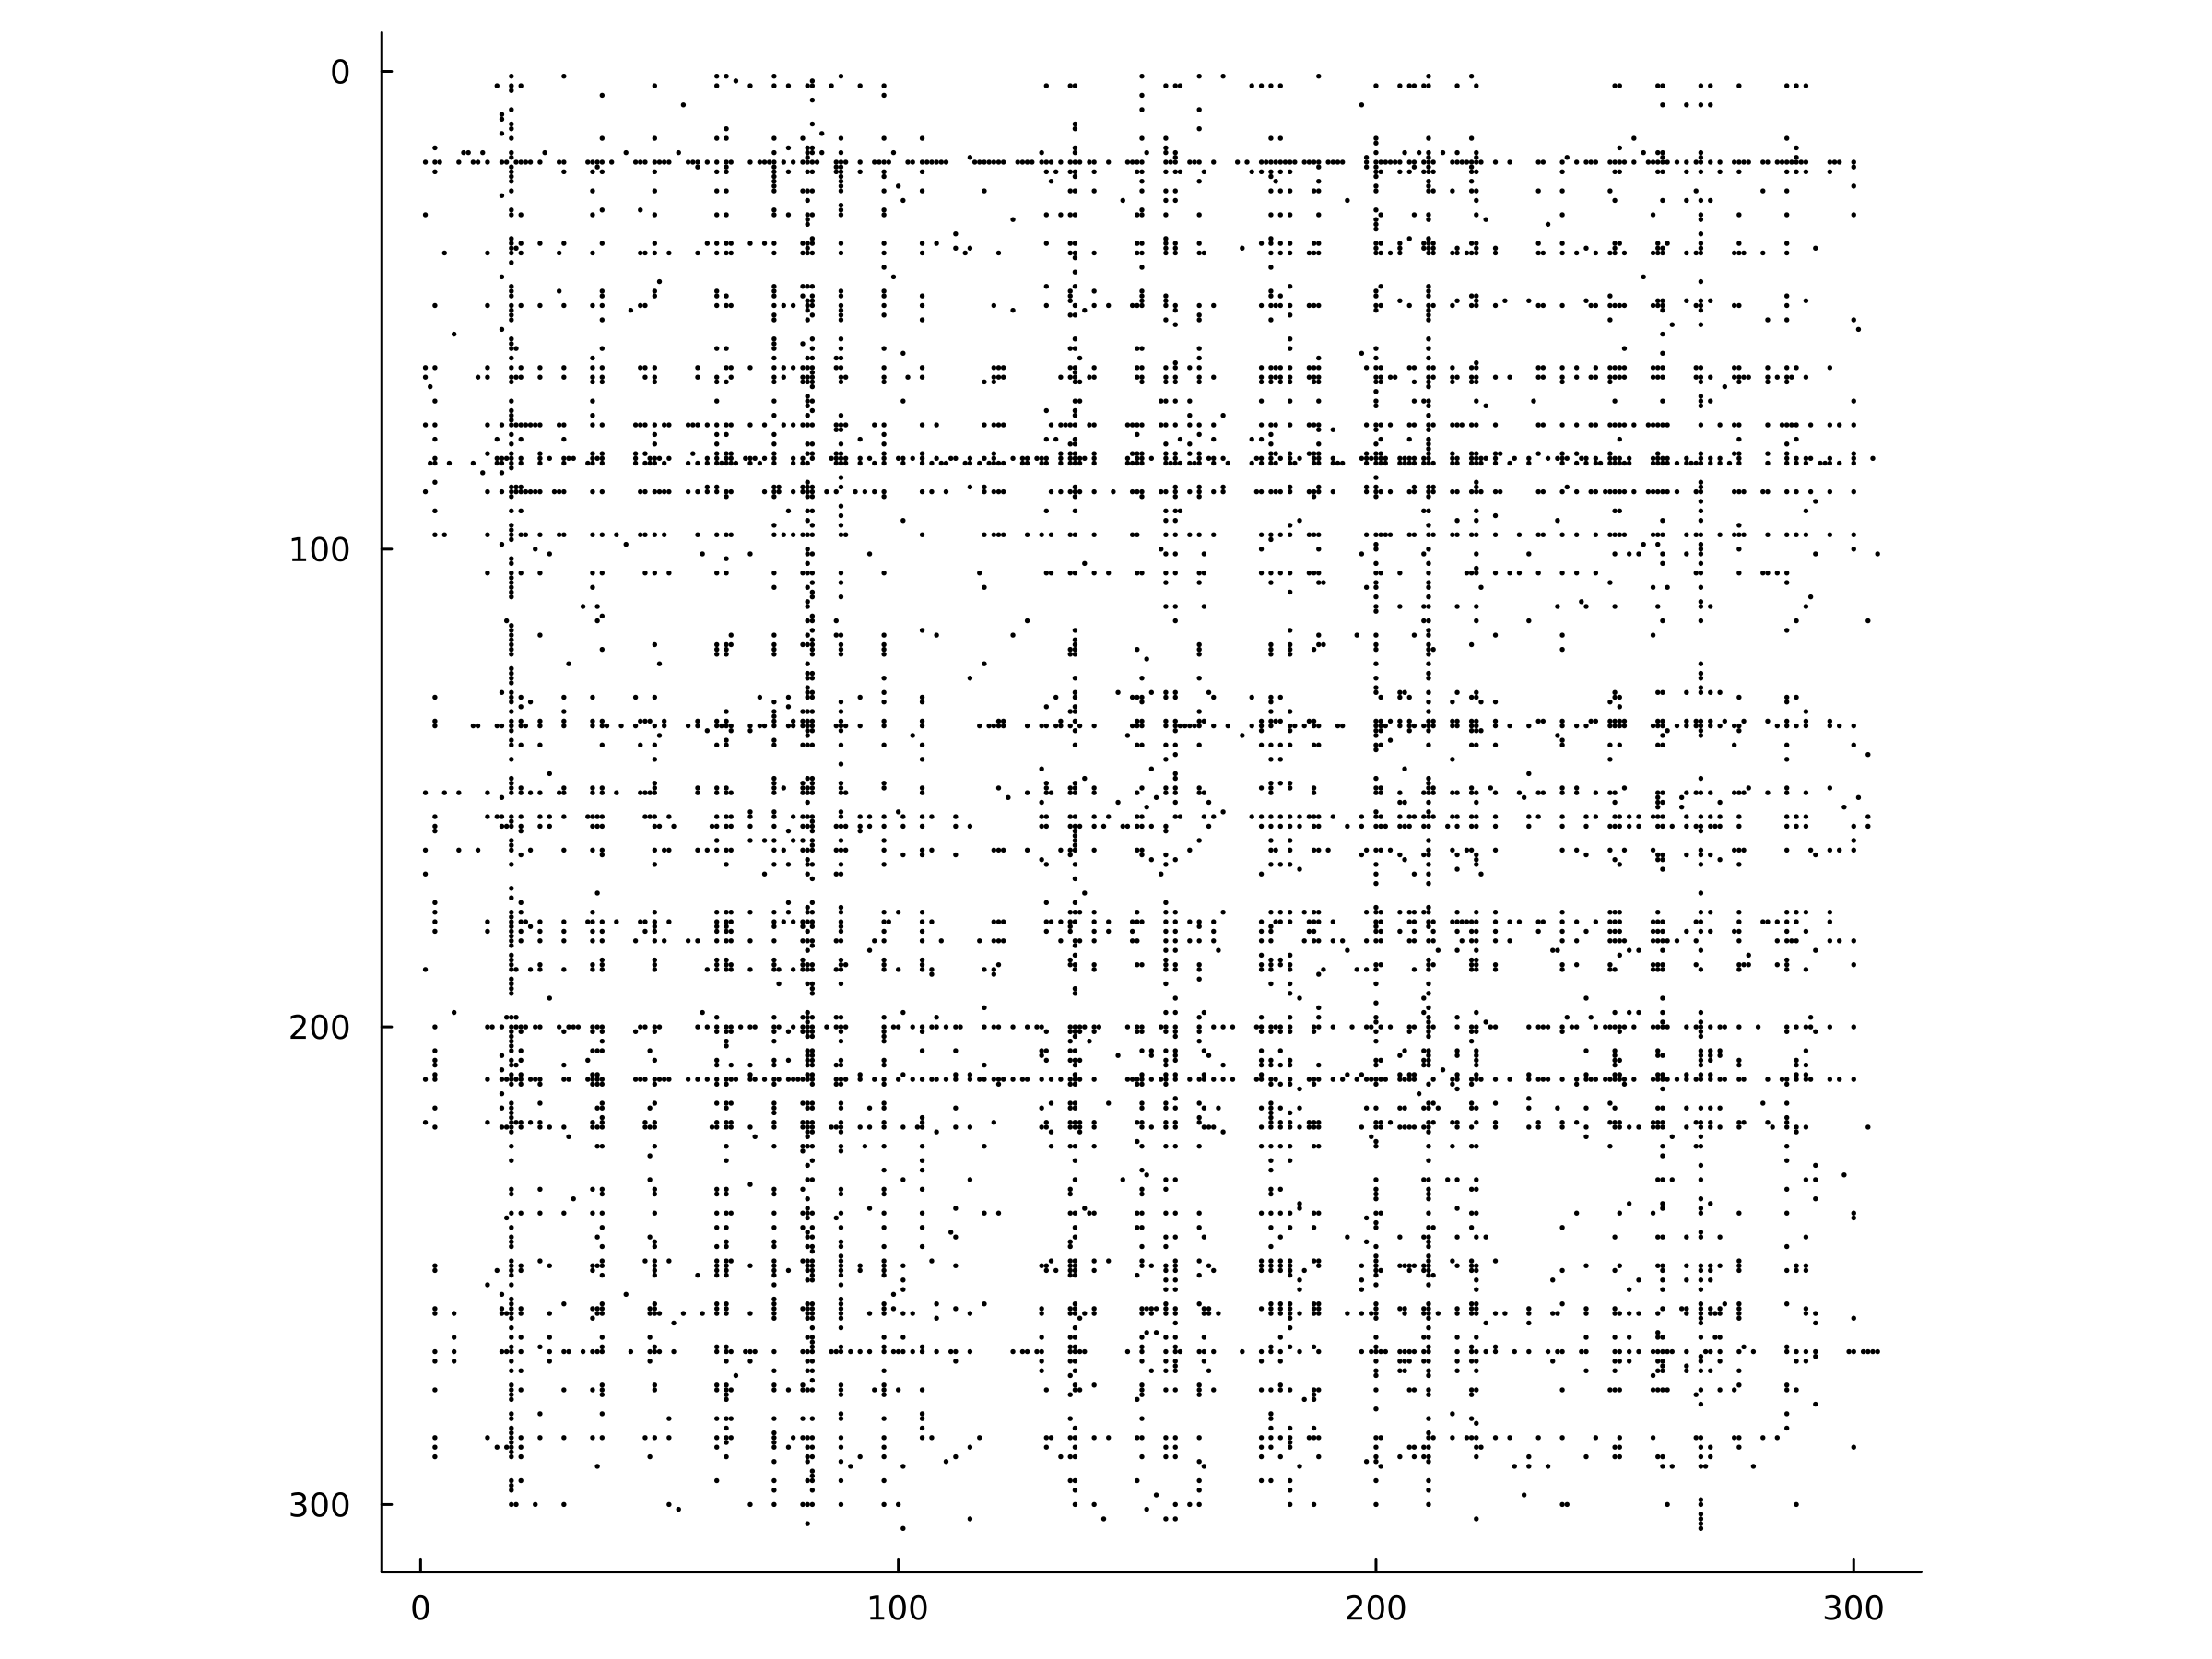

In [10]:
spy(A)

In [11]:
issymmetric(A)

true

There is one popular graphs package in julia and that is the `LightGraphs` package. It does offer a lot of functionality and encourage you to check it out. Nevertheless, the operations we will need here will be basic graph analysis operations and we will make use of the `MatrixNetworks` package. For future reference, and for when you have a "graphs-heavy" project, here's a quick example of how you would build a graph via `LightGraphs`.

In [12]:
L = SimpleGraph(A)

{305, 2834} undirected simple Int64 graph

In [13]:
G=SimpleGraph(10) #SimpleGraph(nnodes,nedges) 
add_edge!(G,7,5)#modifies graph in place.
add_edge!(G,3,5)
add_edge!(G,5,2)

true

For now, we will go back to use the graph's adjacency matrix to perform all the operations we want to perform.

The first is finding the connected components of the graph. Often, it is important to know if the graph you are given is connected specially if you want to later perform diffusion operations on it. Think of it this way: if the graph is disconnected, this means that there is no way for information to travel from one component to another.

#### scomponents

In [14]:
cc = scomponents(A);

cc.sizes will show the size of each component found. Here, only one component was found and it contains all 305 nodes. This is great, because this means that the graph is connected. 

Next, we will look at the degree distribution of this graph.

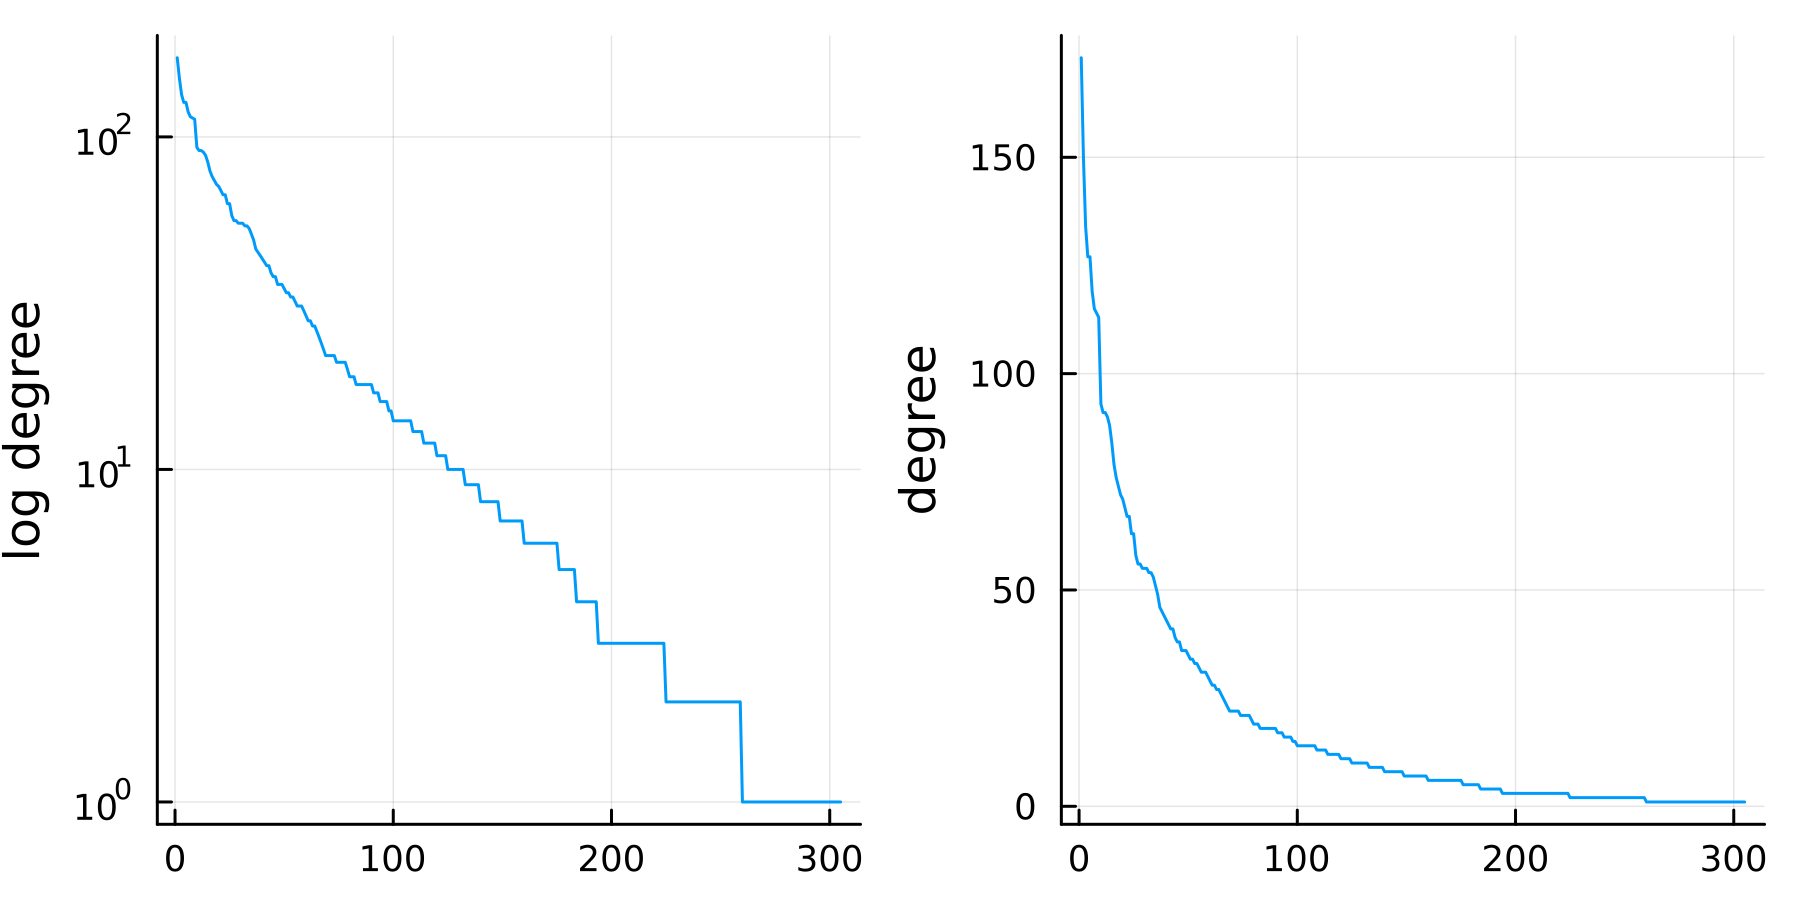

In [15]:
degrees = sum(A,dims=2)[:]
p1 = plot(sort(degrees,rev=true),ylabel="log degree",legend=false,yaxis=:log)
p2 = plot(sort(degrees,rev=true),ylabel="degree",legend=false)
plot(p1,p2,size=(600,300))

This is actually very interesting because it looks like that the airline transportation network seems to fit a powerlaw degree distribution. Knowing that your graph fits a well known model for degree distribution can be very helpful for further studying it. (For instance, there is a lot of literature on graphs that fit power law degree distributions).

Out of curiosity, let's find the airport that has the most connections

In [16]:
maxdegreeid = argmax(degrees)
uairports[maxdegreeid]

"ATL"

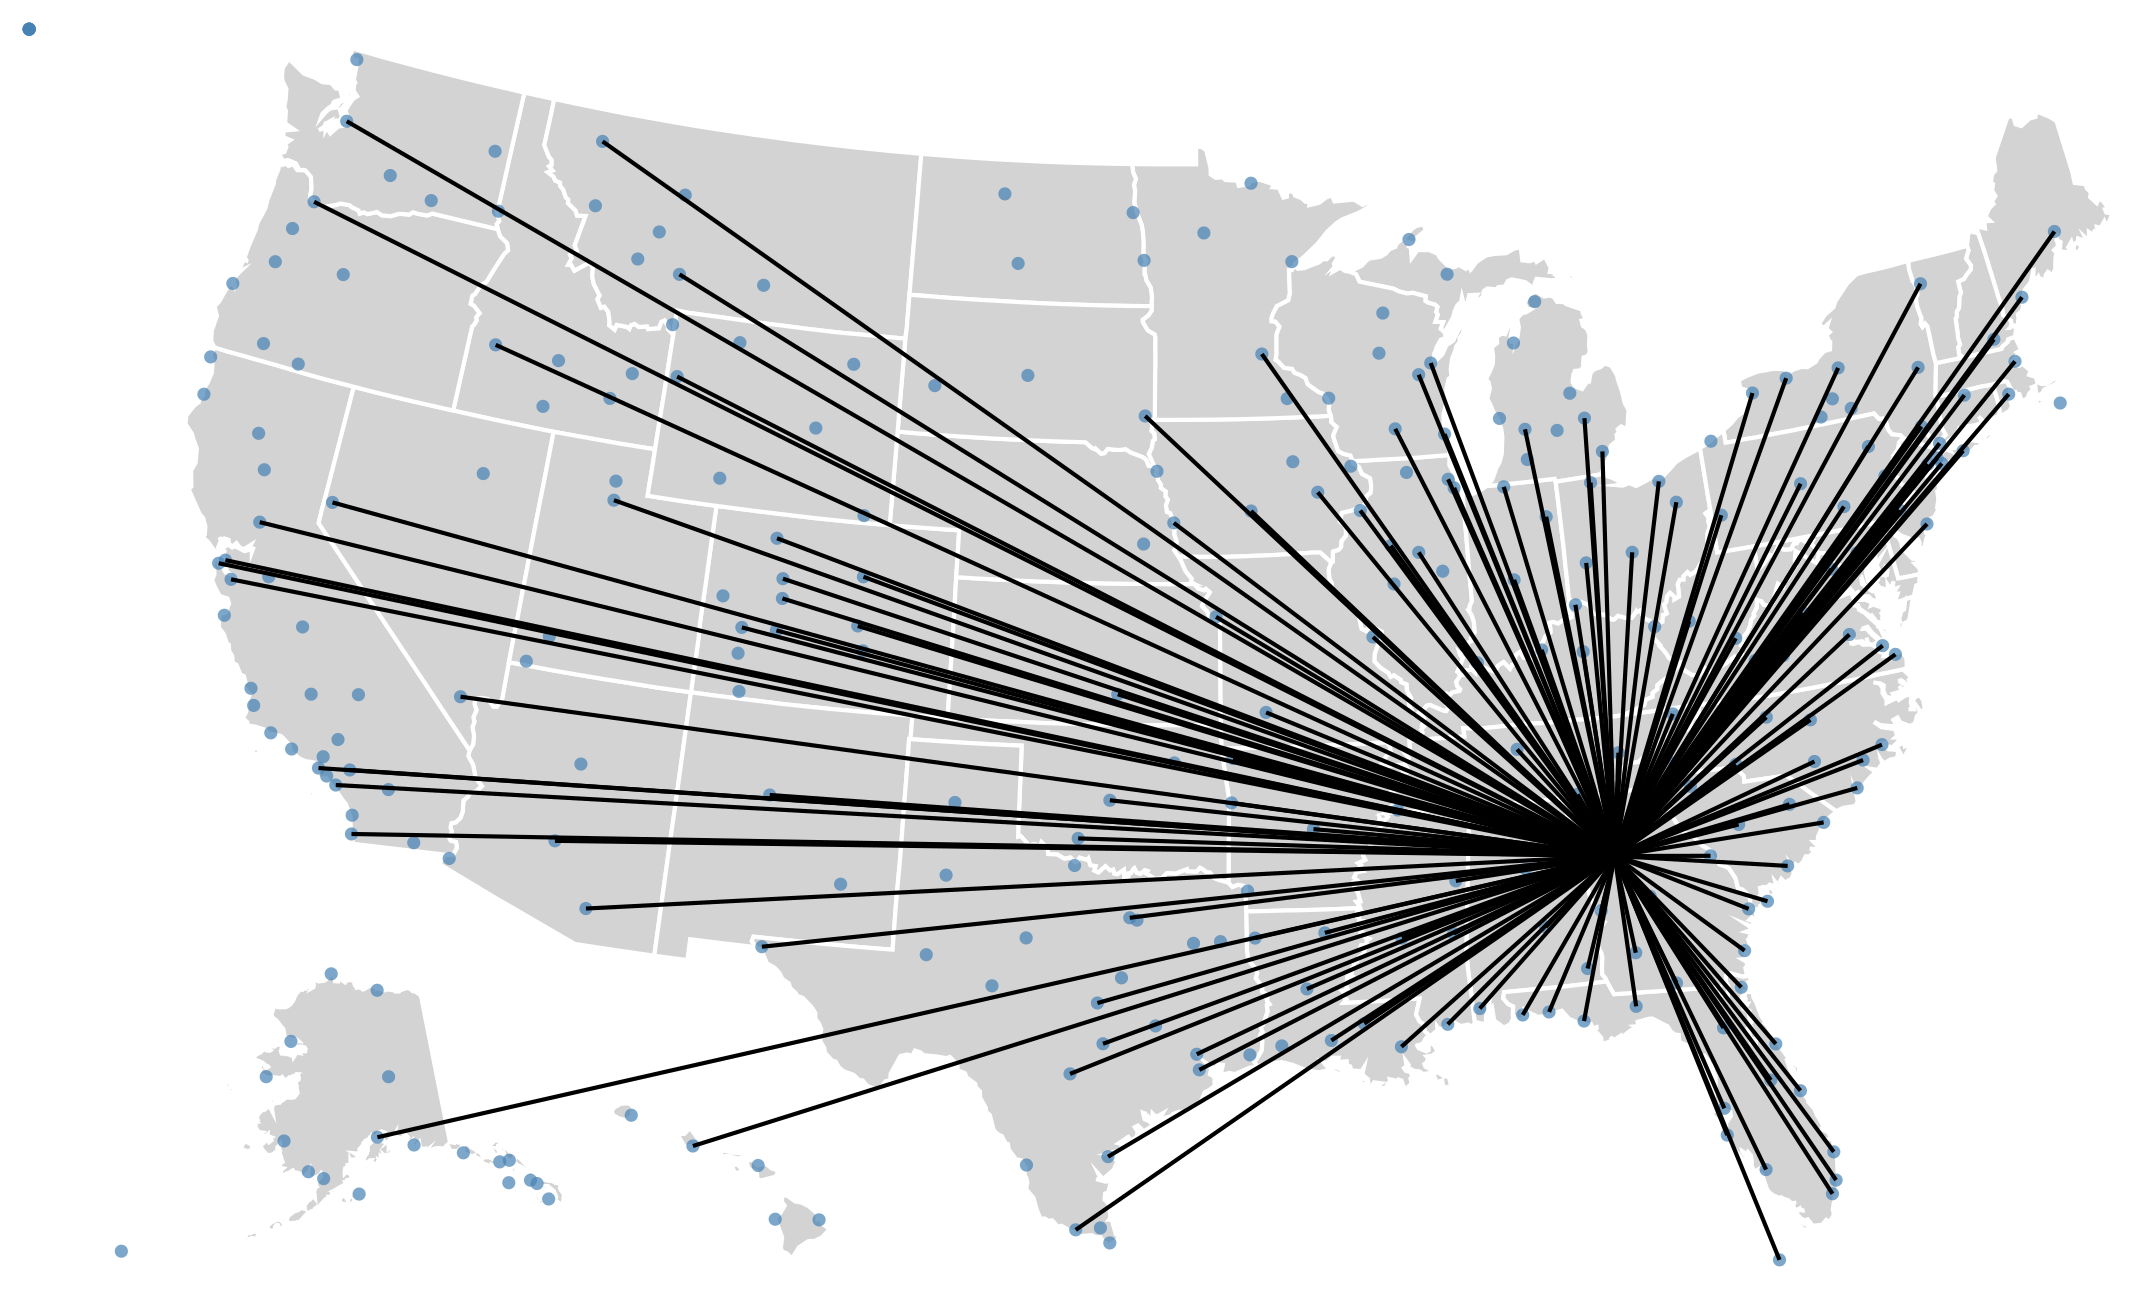

In [17]:
us10m = dataset("us-10m")
p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill=:lightgray,
        stroke=:white
    },
    data={
        values=us10m,
        format={
            type=:topojson,
            feature=:states
        }
    },
    projection={type=:albersUsa},
) +
@vlplot(
    :circle,
    data=airportsdf_subset,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=10},
    color={value=:steelblue}
)+
@vlplot(
    :rule,
    data=flightsairport,
    transform=[
        {filter={field=:origin,equal=:ATL}},
        {
            lookup=:origin,
            from={
                data=airportsdf_subset,
                key=:iata,
                fields=["latitude", "longitude"]
            },
            as=["origin_latitude", "origin_longitude"]
        },
        {
            lookup=:destination,
            from={
                data=airportsdf_subset,
                key=:iata,
                fields=["latitude", "longitude"]
            },
            as=["dest_latitude", "dest_longitude"]
        }
    ],
    projection={type=:albersUsa},
    longitude="origin_longitude:q",
    latitude="origin_latitude:q",
    longitude2="dest_longitude:q",
    latitude2="dest_latitude:q"
)

p |> show_map

### 🟡Shortest path problem
Finding the shortest path between two nodes. We will use Dijkstra's algorithm.

In [18]:
ATL_paths = dijkstra(A,maxdegreeid);

We will find a node that has the longest distance from ATL.

In [19]:
@show stop1 = argmax(ATL_paths[1])
@show uairports[stop1]
;

stop1 = argmax(ATL_paths[1]) = 123
uairports[stop1] = "GST"


In [20]:
@show stop2 = ATL_paths[2][stop1]
@show uairports[stop2]
;

stop2 = (ATL_paths[2])[stop1] = 152
uairports[stop2] = "JNU"


In [21]:
@show stop3 = ATL_paths[2][stop2]
@show uairports[stop3]
;

stop3 = (ATL_paths[2])[stop2] = 259
uairports[stop3] = "SEA"


In [22]:
@show stop4 = ATL_paths[2][stop3]
@show uairports[stop4]
;

stop4 = (ATL_paths[2])[stop3] = 19
uairports[stop4] = "ATL"


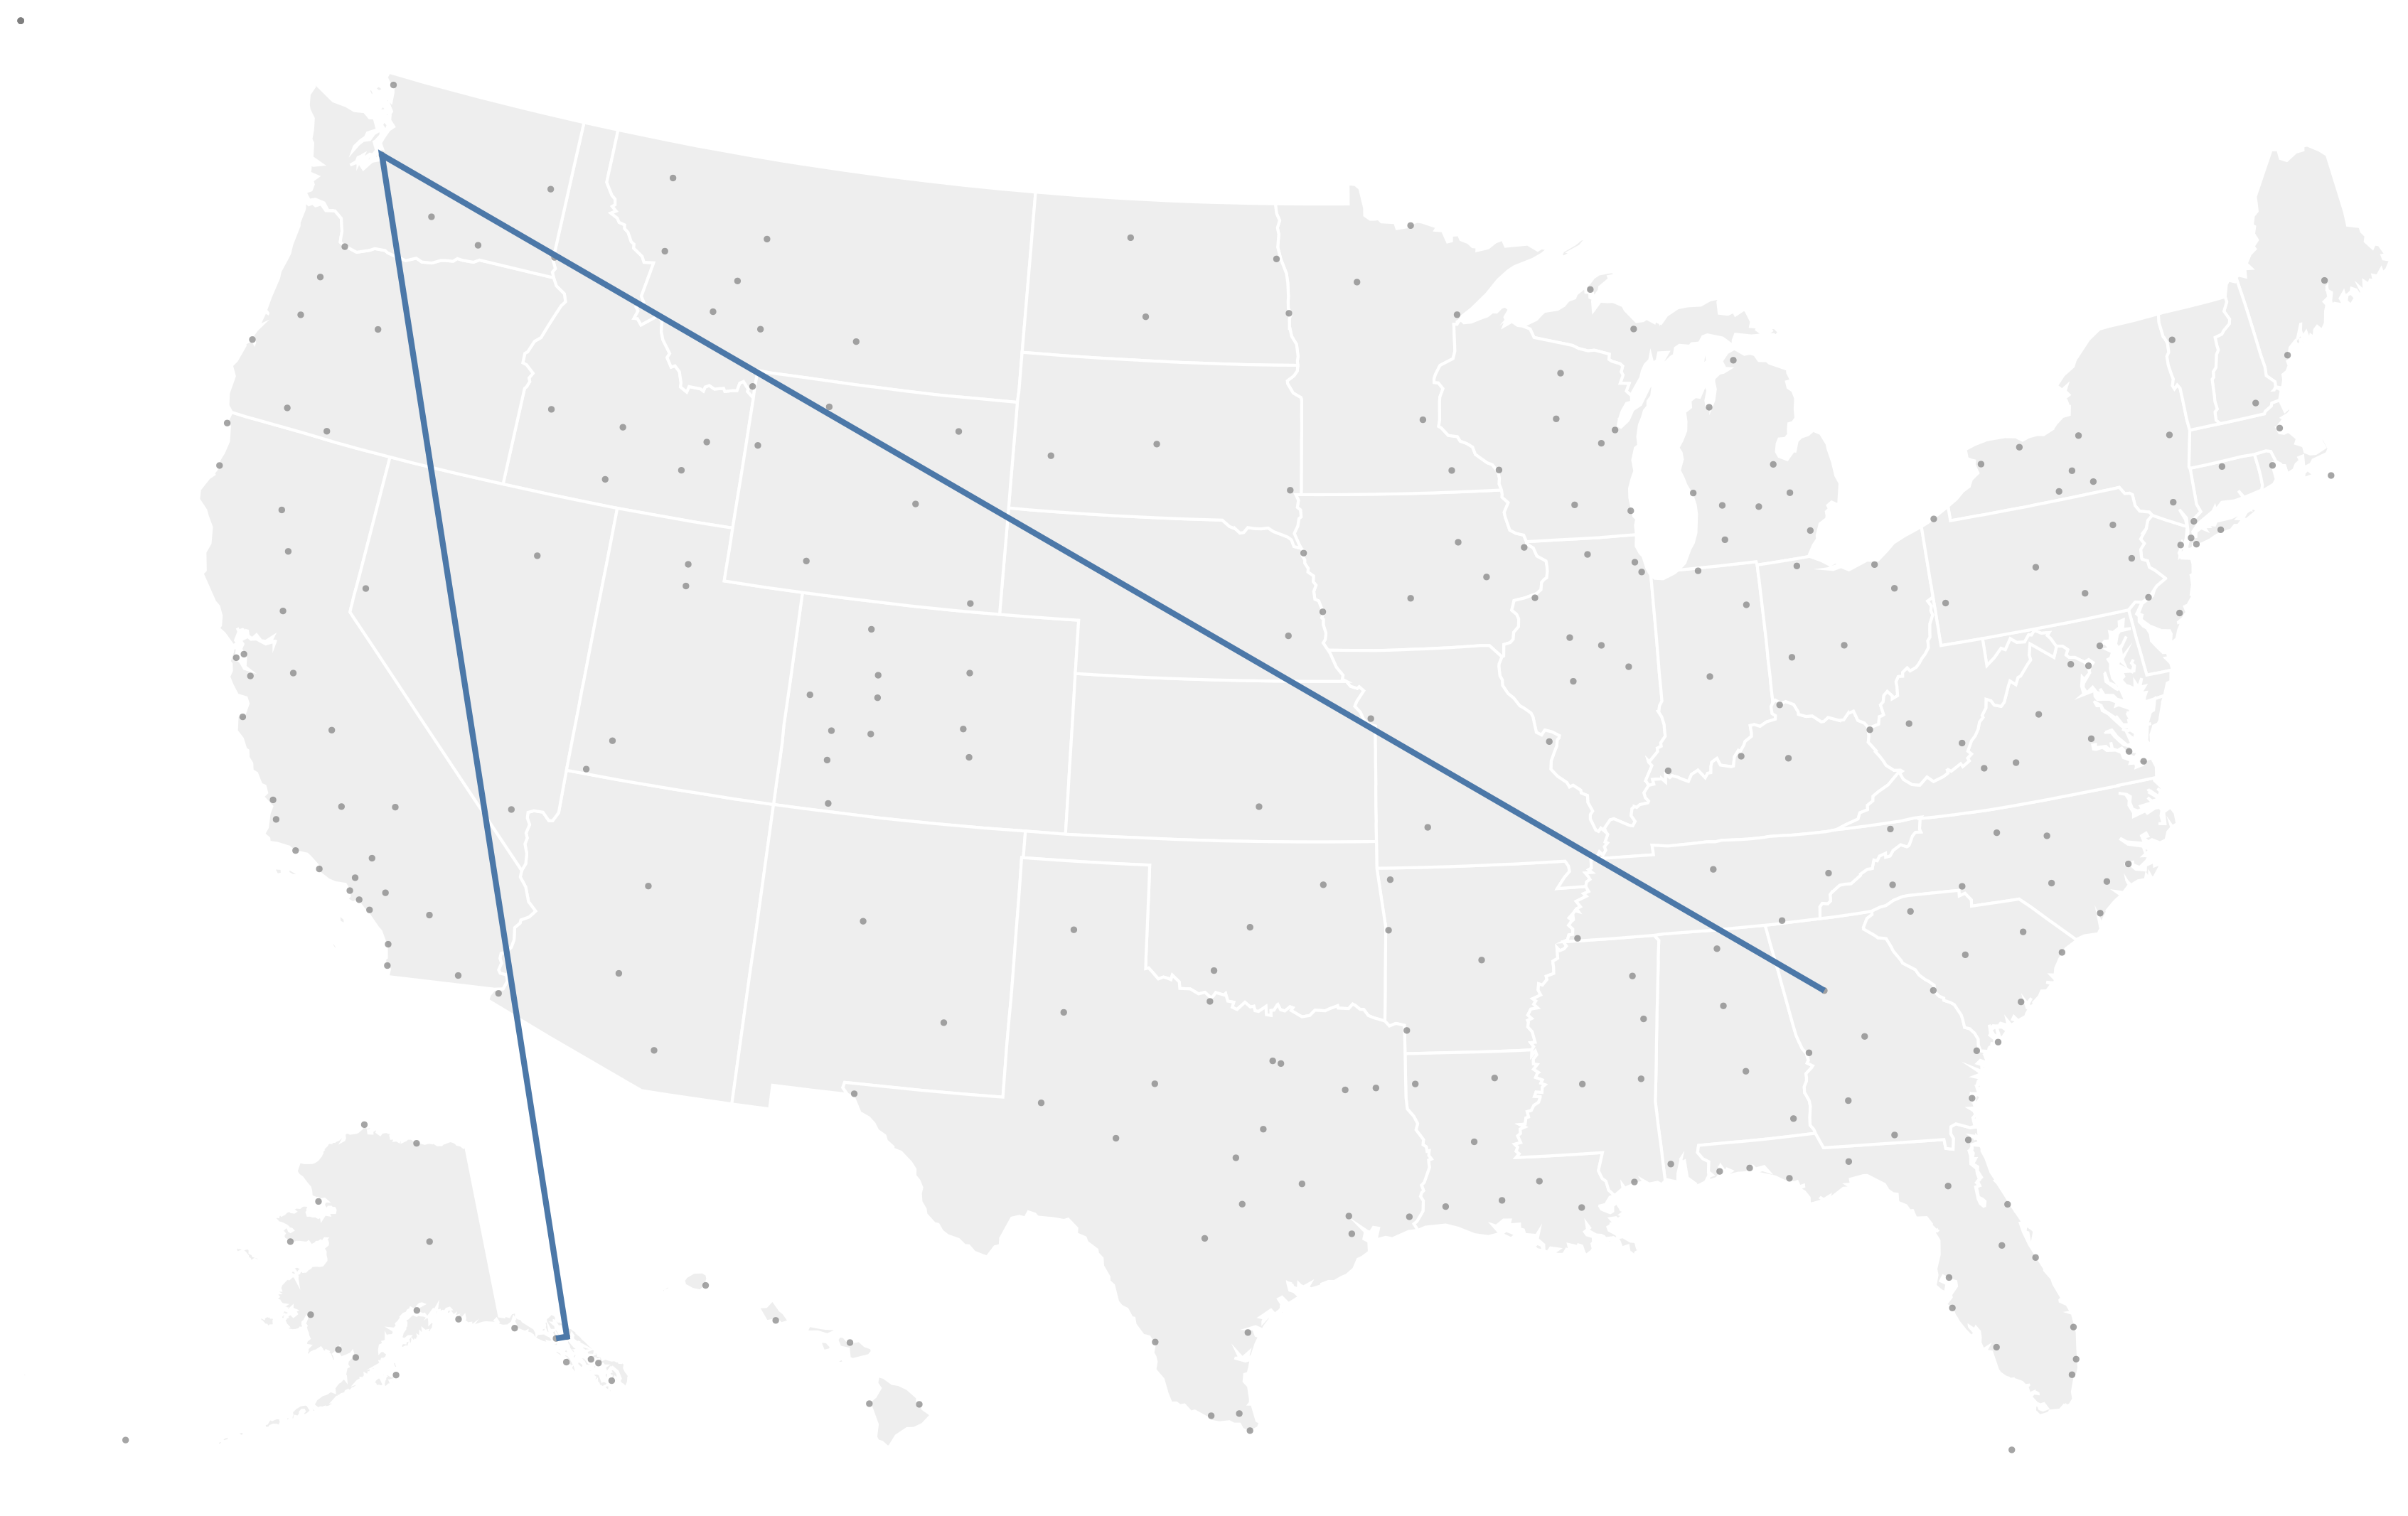

In [23]:
using VegaLite, VegaDatasets

us10m = dataset("us-10m")
airports = dataset("airports")

p = @vlplot(width=800, height=500) +
@vlplot(
    mark={
        :geoshape,
        fill="#eee",
        stroke=:white
    },
    data={
        values=us10m,
        format={
            type=:topojson,
            feature=:states
        }
    },
    projection={type=:albersUsa},
) +
@vlplot(
    :circle,
    data=airportsdf_subset,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=5},
    color={value=:gray}
) +
@vlplot(
    :line,
    data={
        values=[
            {airport=:ATL,order=1},
            {airport=:SEA,order=2},
            {airport=:JNU,order=3},
            {airport=:GST,order=4}
        ]
    },
    transform=[{
        lookup=:airport,
        from={
            data=airports,
            key=:iata,
            fields=["latitude","longitude"]
        }
    }],
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    order={field=:order,type=:ordinal}
)

p |> show_map

We can look at distances from other airports too, and put the whole thing in a function.

In [24]:
nodeid = argmin(degrees)
@show uairports[nodeid]
d = dijkstra(A,nodeid)
argmax(d[1]),uairports[argmax(d[1])]

uairports[nodeid] = "ABY"


(123, "GST")

In [25]:
function find_path(d,id)
    shortestpath = zeros(Int,1+Int.(d[1][id]))
    shortestpath[1] = id
    for i = 2:length(shortestpath)
        shortestpath[i] = d[2][shortestpath[i-1]]
    end
    return shortestpath
end
p = find_path(d,123)
uairports[p]

5-element Vector{String}:
 "GST"
 "JNU"
 "ANC"
 "ATL"
 "ABY"

### 🟡Minimum Spanning Tree (MST)
The next problem is forming a minimum spanning tree on the graph. The idea of a minimum spanning tree is to connect all nodes in the graph with as little edges as possible. We will use Prim's algorithm for this problem.

In [26]:
ti,tj,tv,nverts = mst_prim(A);

We will form a new DataFrame with a new set of edges (from the MST)

In [27]:
df_edges = DataFrame(:ei=>uairports[ti],:ej=>uairports[tj]);

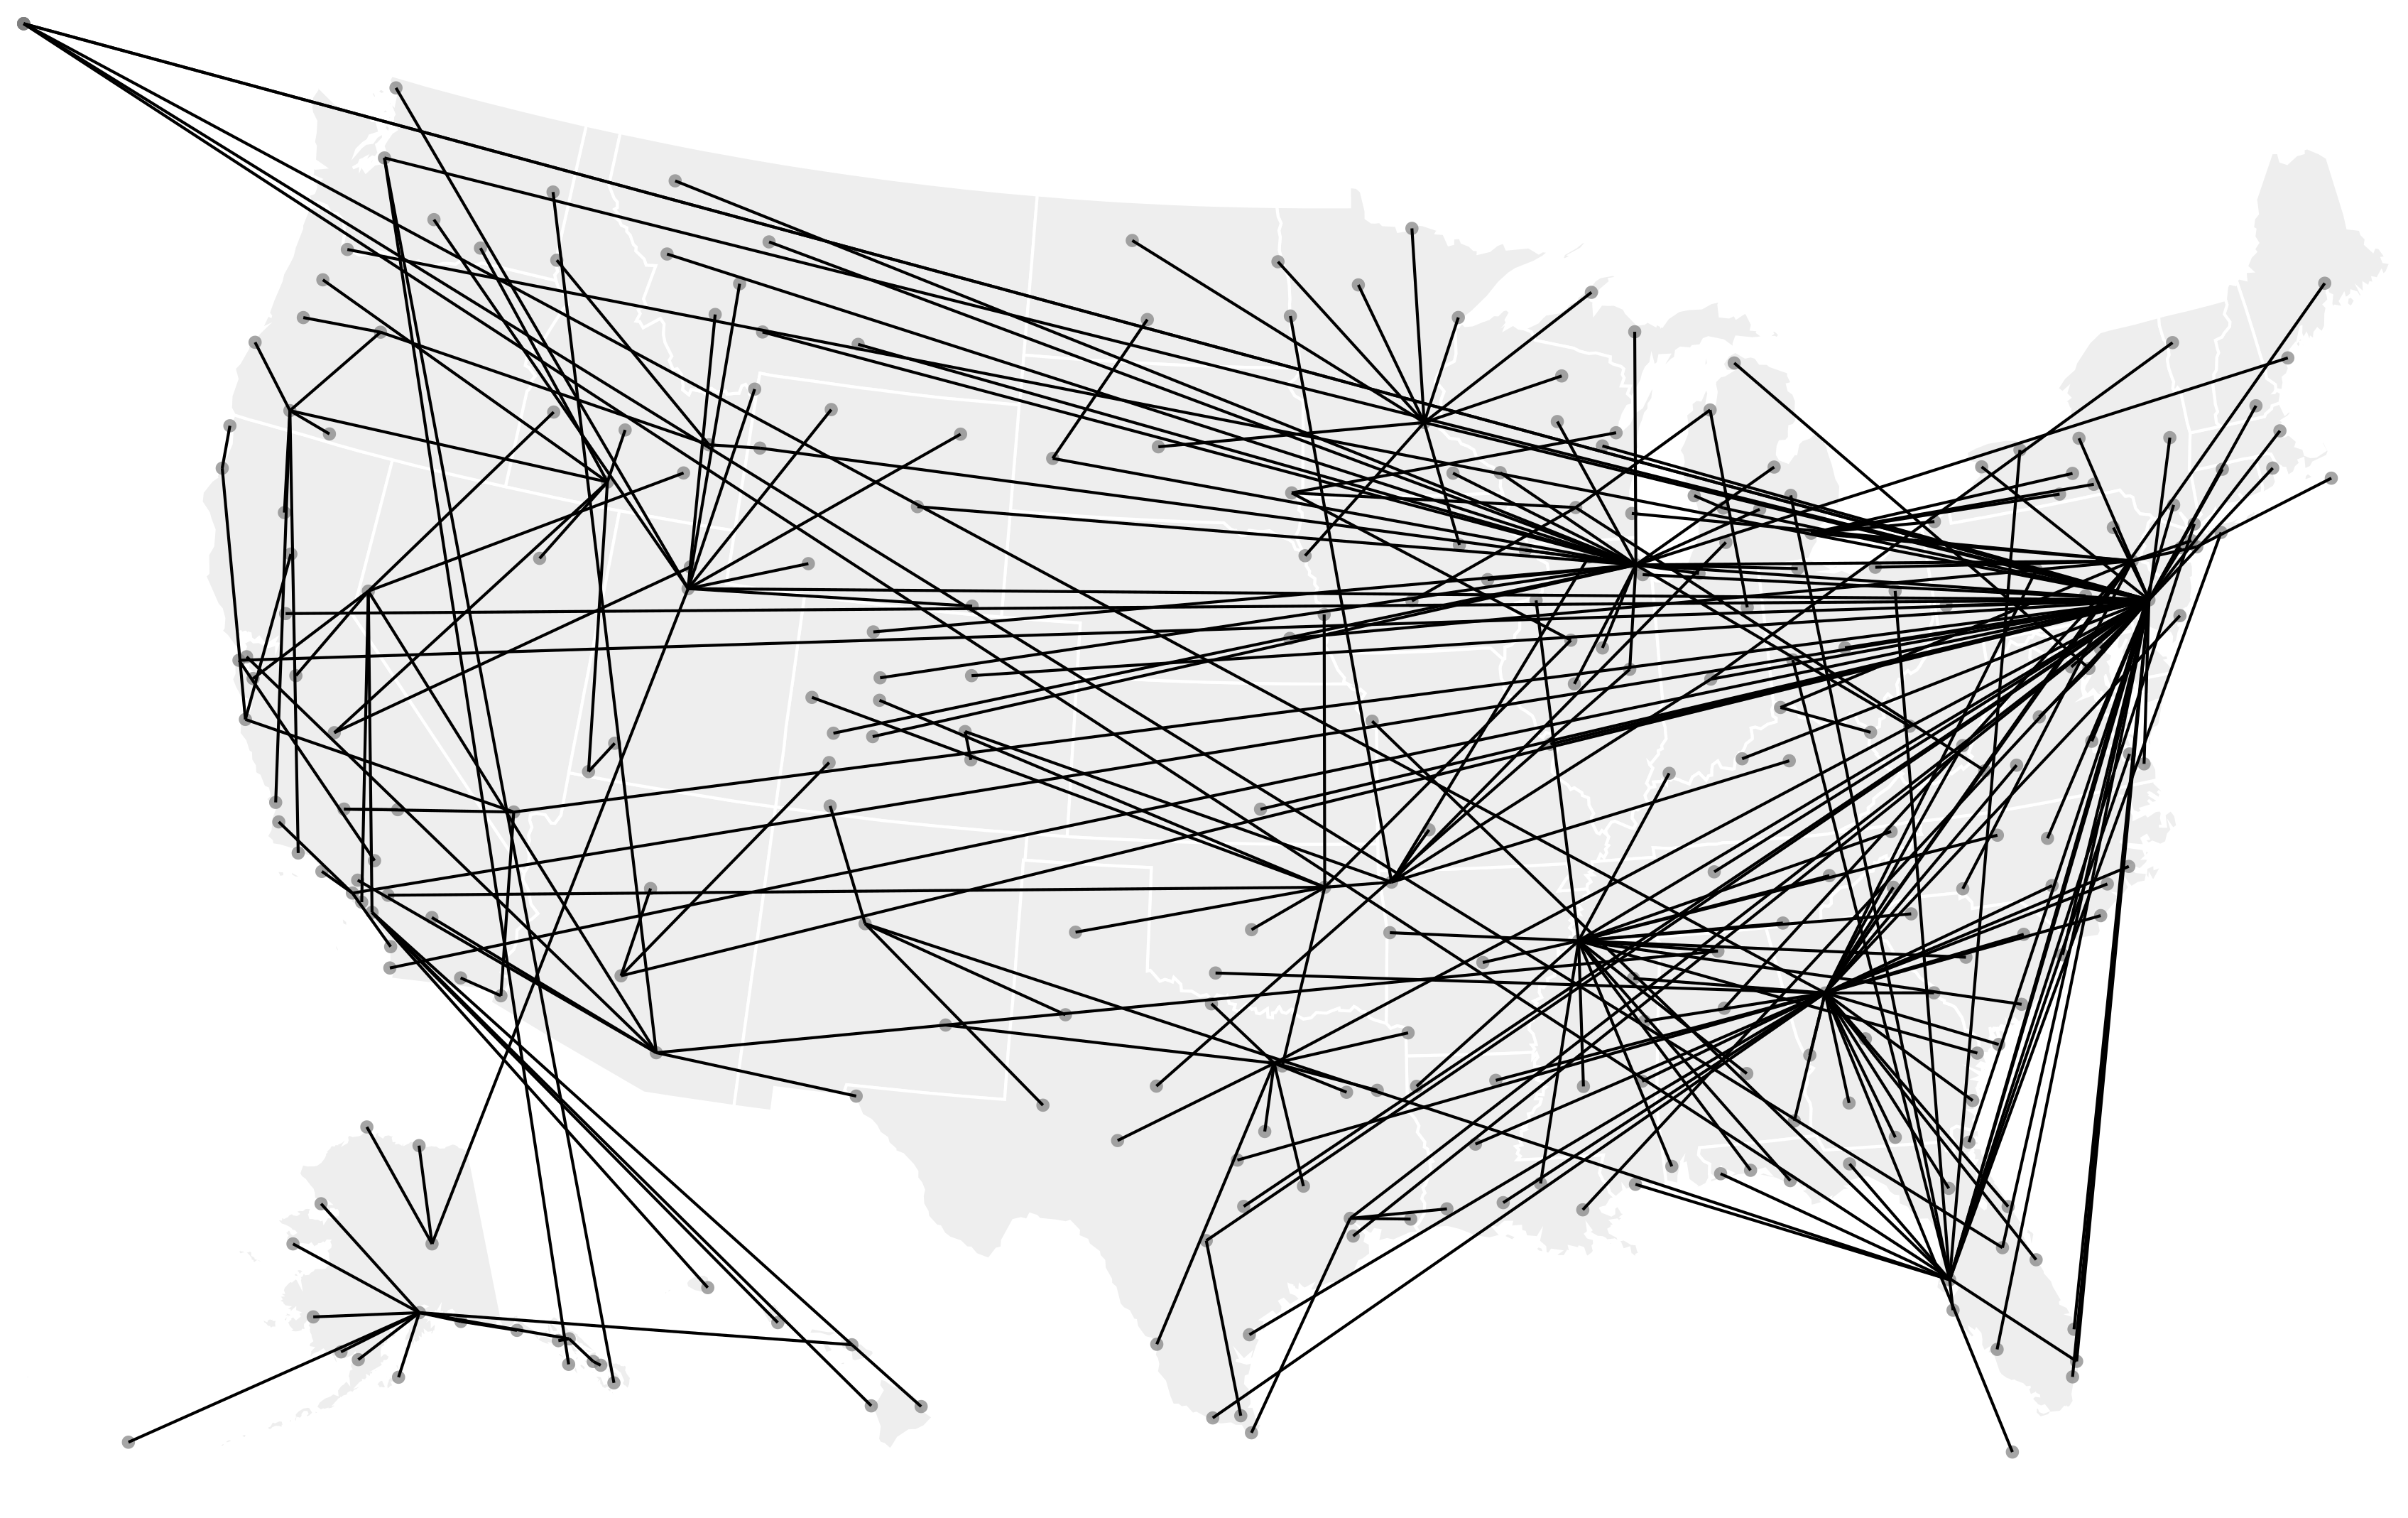

In [28]:
p = @vlplot(width=800, height=500) +
@vlplot(
    mark={
        :geoshape,
        fill="#eee",
        stroke=:white
    },
    data={
        values=us10m,
        format={
            type=:topojson,
            feature=:states
        }
    },
    projection={type=:albersUsa},
) +
@vlplot(
    :circle,
    data=airportsdf_subset,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size={value=20},
    color={value=:gray}
) +
@vlplot(
    :rule,
    data=df_edges, #data=flightsairport,
    transform=[
        {
            lookup=:ei,
            from={
                data=airportsdf_subset,
                key=:iata,
                fields=["latitude", "longitude"]
            },
            as=["originx", "originy"]
        },
        {
            lookup=:ej,
            from={
                data=airportsdf_subset,
                key=:iata,
                fields=["latitude", "longitude"]
            },
            as=["destx", "desty"]
        }
    ],
    projection={type=:albersUsa},
    longitude="originy:q",
    latitude="originx:q",
    longitude2="desty:q",
    latitude2="destx:q"
)

p |> show_map

### 🟡PageRank
PageRank is the algorithm that got Google started. The idea is: given an network of connections between multiple nodes (web pages in the cae of Google), is there a way to return a list of ranked nodes? PageRank provides this ranking. Obviously, nodes can be ranked in several different ways but PageRank remains to be one of the most popular methods in network analysis. Let's check out the documentation of `pagerank` below.

Now, we will run PageRank on our adjacency matrix `A`.

In [29]:
v = MatrixNetworks.pagerank(A,0.85);

Here, note that the return vector `v` sums to `1`.

In [30]:
insertcols!(airportsdf_subset,7,:pagerank_value=>v);

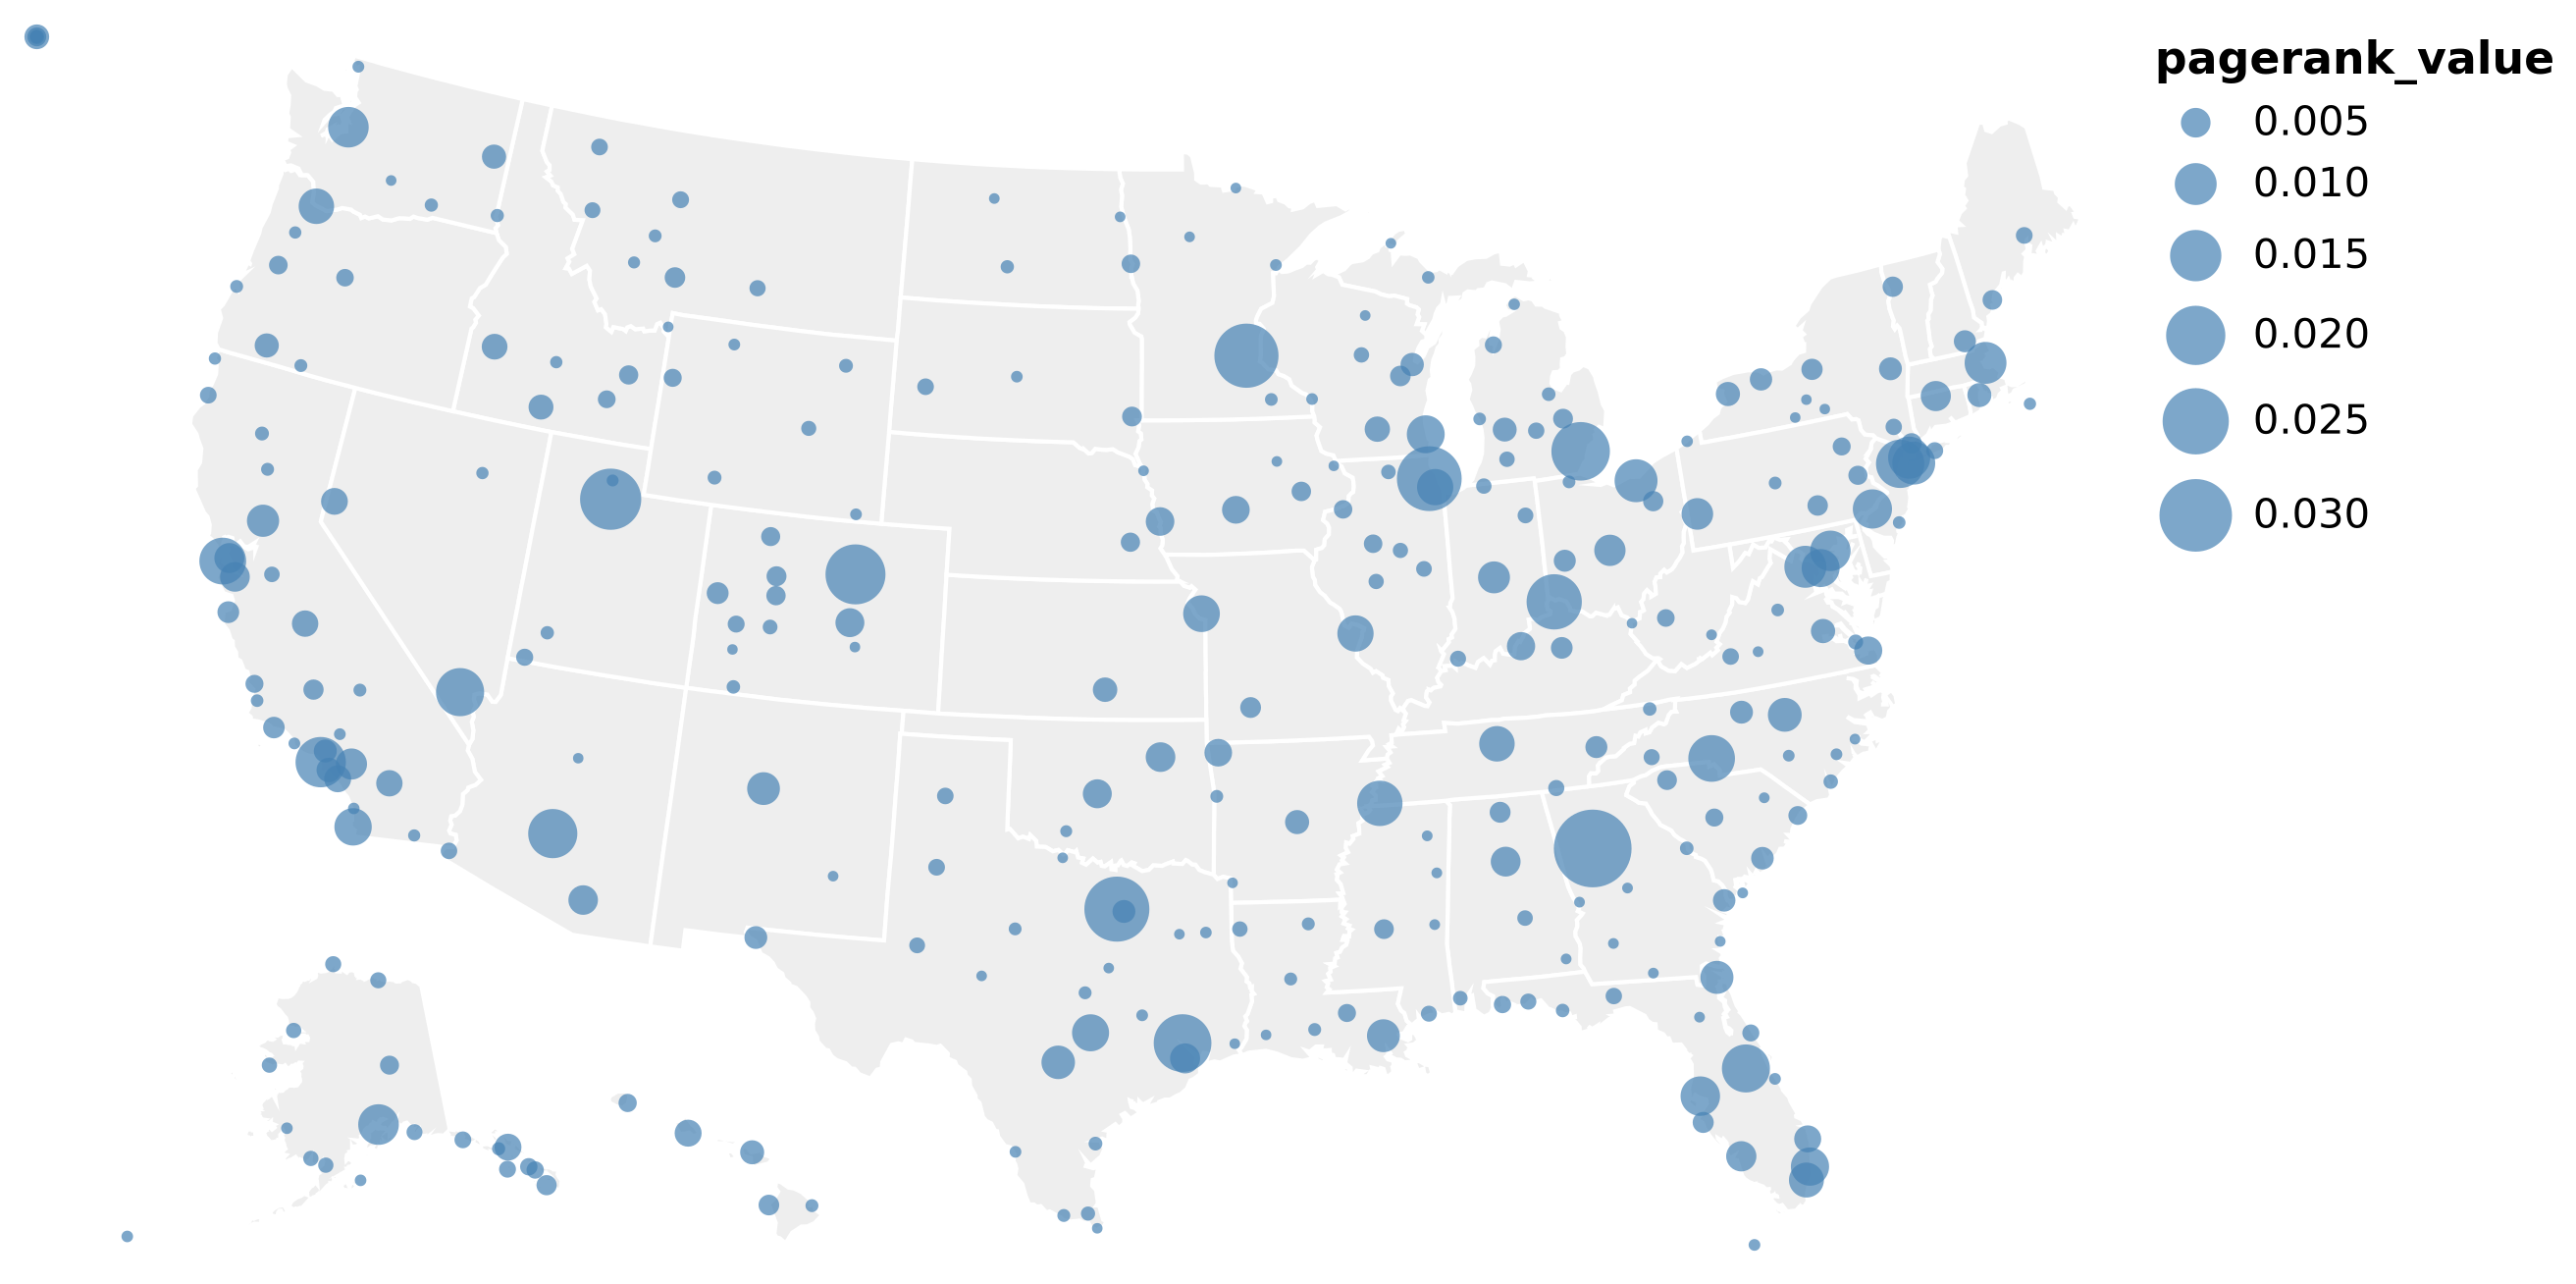

In [31]:
p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill="#eee",
        stroke=:white
    },
    data={
        values=us10m,
        format={
            type=:topojson,
            feature=:states
        }
    },
    projection={type=:albersUsa},
) +
@vlplot(
    :circle,
    data=airportsdf_subset,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size="pagerank_value:q",
    color={value=:steelblue}
)
p |> show_map

### 🟡Clustering Coefficients
From Wikipedia: The local clustering coefficient of a vertex (node) in a graph quantifies how close its neighbours are to being a clique (complete graph).

This means that if for example, a node is connected to two nodes that are also connected to each other, that node's clustering coeefficient is 1. This can be a good metric to find out which nodes tend to have tight clusters around them. Let's look at the documentation of `clustercoeffs` from MatrixNetworks.

In [32]:
cc = clustercoeffs(A)
cc[findall(cc.<=eps())] .= 0;

In [33]:
insertcols!(airportsdf_subset,7,:ccvalues=>cc);

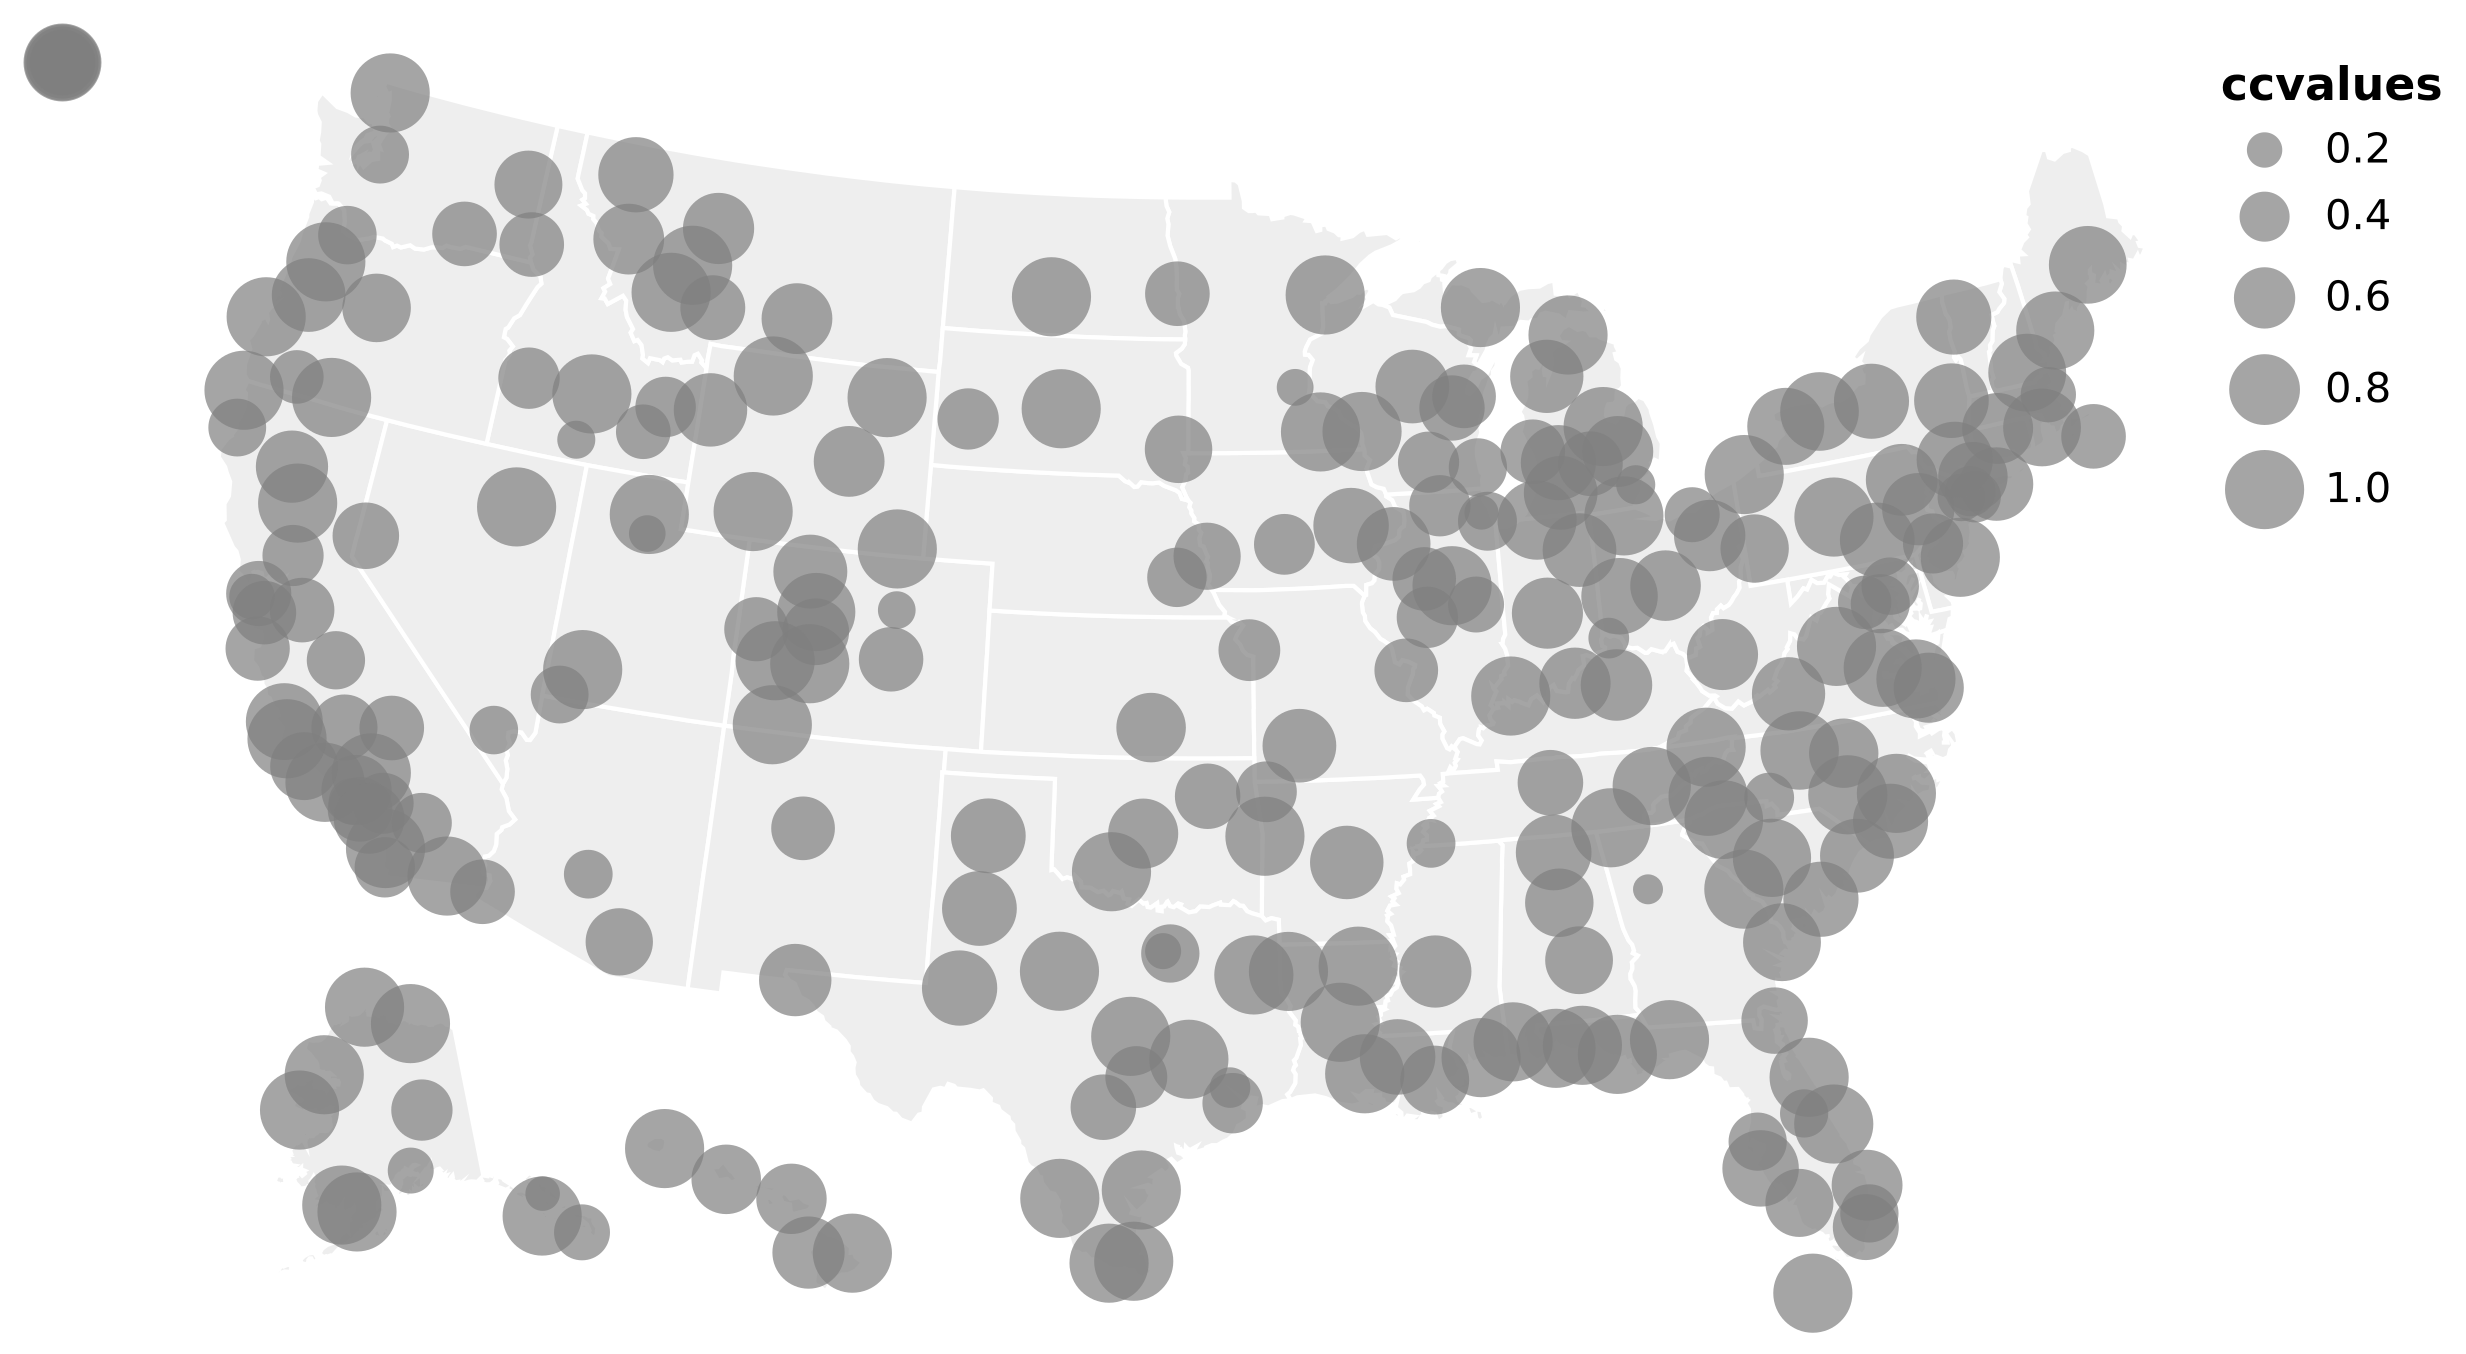

In [34]:
p = @vlplot(width=500, height=300) +
@vlplot(
    mark={
        :geoshape,
        fill="#eee",
        stroke=:white
    },
    data={
        values=us10m,
        format={
            type=:topojson,
            feature=:states
        }
    },
    projection={type=:albersUsa},
) +
@vlplot(
    :circle,
    data=airportsdf_subset,
    projection={type=:albersUsa},
    longitude="longitude:q",
    latitude="latitude:q",
    size="ccvalues:q",
    color={value=:gray}
)
p |> show_map

# Finally...
After finishing this notebook, you should be able to:
- take a list of connections between nodes and form an adjacency matrix out of them
- use the LightGraphs package
- use Dijkstra, MST, and PageRank methods
- find the clustering coefficients of nodes in a graph